# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

In [1]:
# Import all the necessary libraries (there are a lot!)

# Data manipulation
import numpy as np 
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (BaggingClassifier, 
                              RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier,
                              StackingClassifier)
# Model evaluation
from sklearn import metrics
from sklearn.metrics import (confusion_matrix,
                             make_scorer,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import XGBoost Classifier
from xgboost import XGBClassifier

In [3]:
# Import the data
data = pd.read_csv('EasyVisa.csv')

## Data Overview

- Observations
- Sanity checks

In [4]:
# Check the first 5 rows
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [5]:
# Check the shape of the data
data.shape

(25480, 12)

In [6]:
# Check for data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [7]:
# Check for duplicated data
data[data.duplicated()].count()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

#### Initial Observations:

<li>A few boolean-appearing features; Y/N</li>
<li>Numeric columns vary wildly in scale</li>
<li>No missing data</li>
<li>Lots of object data types (need dealt with).</li>
<li>No duplicated entries.</li>

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

In [8]:
# Drop the case_id as it acts as a unique identifier 
# for the database and has no relation to the data.
data = data.drop('case_id', axis = 1)

In [9]:
# Create a variable for all categorical datatypes
cat_cols = data.select_dtypes(include = 'object').columns.tolist()
cat_cols

['continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status']

In [10]:
# Create a variable for all numeric datatypes
num_cols = data.select_dtypes(include = np.number).columns.tolist()
num_cols

['no_of_employees', 'yr_of_estab', 'prevailing_wage']

In [11]:
# Convert the categorical columns to the 'category' datatype
data[cat_cols] = data[cat_cols].astype('category')

In [12]:
# Check the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  category
 1   education_of_employee  25480 non-null  category
 2   has_job_experience     25480 non-null  category
 3   requires_job_training  25480 non-null  category
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  category
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  category
 9   full_time_position     25480 non-null  category
 10  case_status            25480 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 797.7 KB


### Univariate and Bivariate Analysis

In [13]:
# Create a function for a stacked boxplot, normal histogram, and histogram with 
# hue variable for the target variable.

def box_hist_hue_plot(data, col, hue):
    
    # Set up the subplots
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize = (10,7))
    
    # Plots
    sns.boxplot(data = data, x = col, ax = ax1, showmeans = True)
    sns.histplot(data = data, x = col, ax = ax2)
    sns.histplot(data = data, x = col, ax = ax3, hue = hue)
    
    # Show result
    plt.show

In [14]:
# Create a function for bar plots and bar plots with the hue variable set to
# the target variable.

def bar_hue_plot(data, col, hue):
    
    # Set up subplots
    f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10, 7))
    ax1.set_title('Normal Barplot')
    ax2.set_title('Barplot with Target Hue')
    
    # Plots
    sns.countplot(data = data, x = col, ax = ax1)
    sns.countplot(data = data, x = col, ax = ax2, hue = hue)
    
    # Show result
    plt.show()

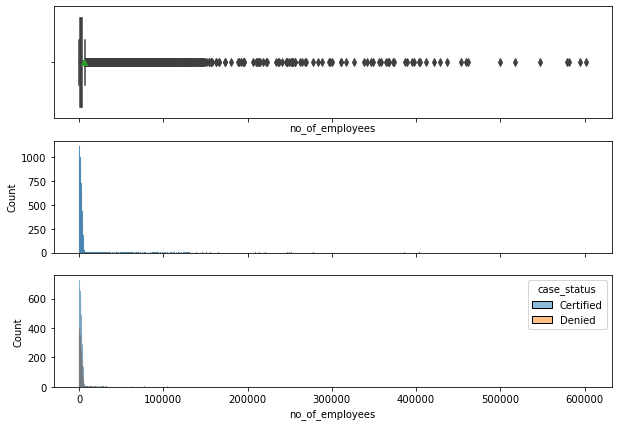

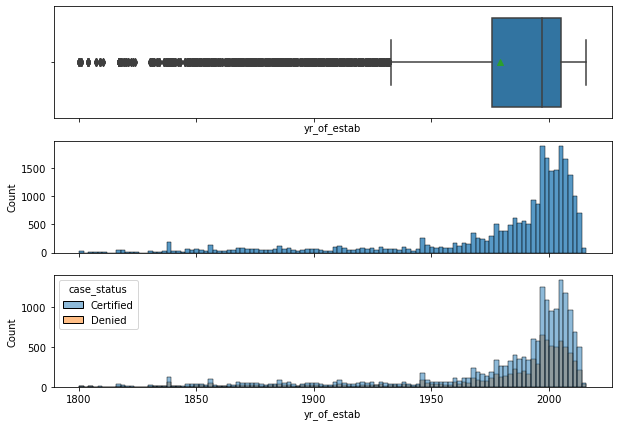

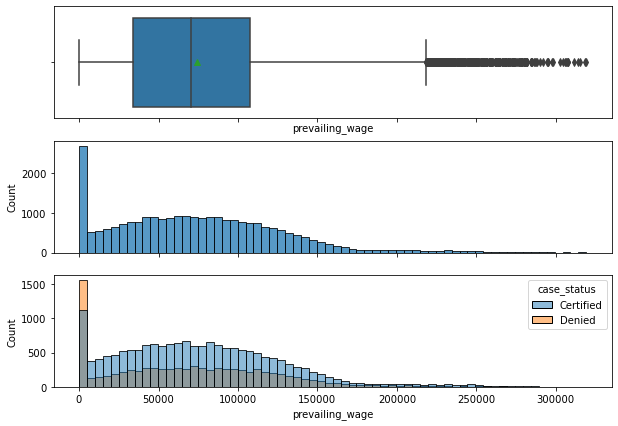

In [15]:
# Create a box hue hist plot for all of the numerical data. 
for col in num_cols:
    
    box_hist_hue_plot(data, col, 'case_status')

#### Observations:

`no_of_employees` 

- Very heavily skewed right.
- Significant outliers. Likely due to very large and very small companies represented in the data.
- Due to the heavy skew, it appears the target variable roughly follows the entire data distribution.

`yr_of_estab`

- Heavily skewed left.
- Significant outliers. Likely due to the varying age of companies represented in the data.
- The target variable distribution roughly follows the whole data distribution.

`prevailing wage`

- Somewhat normally distributed with a large spike around 0.
- Significant outliers on the high end. This may be due to varying currencies.
- The target variable distribution roughly follows the whole data distribution.

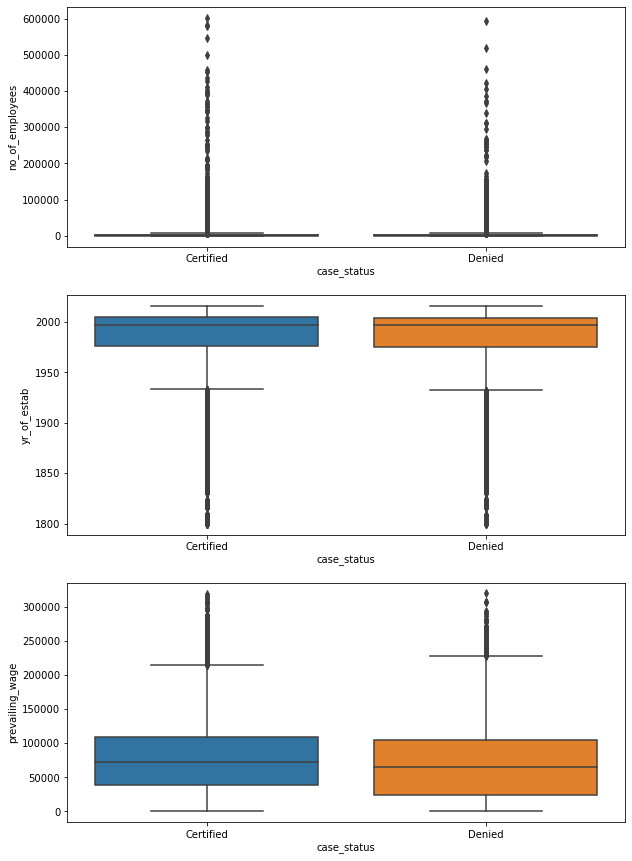

In [16]:
# Create a boxplot for each numerical column with respect to the target variable.

plt.figure(figsize = (10, 15))

# Loop through the numerical columns
for i, col in enumerate(num_cols):
    
    # Create the subplots
    plt.subplot((len(num_cols)), 1, i+1)
    sns.boxplot(data = data, x = 'case_status', y = col)
    
# Show result
plt.show()

#### Observations:

- Due to the heavy skew in most of the variables, it is difficult to determine significant differences in the numeric variables with respect to the target variable.

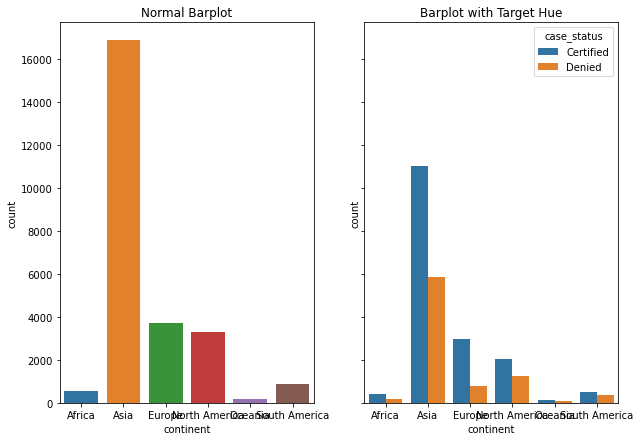

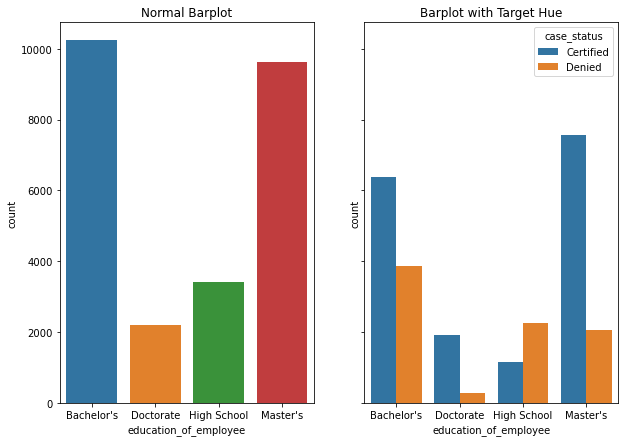

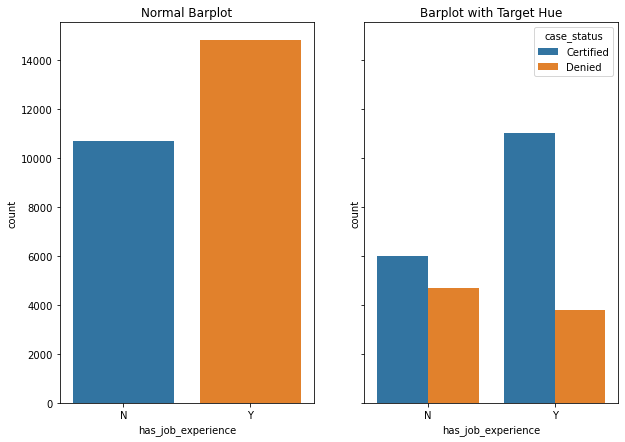

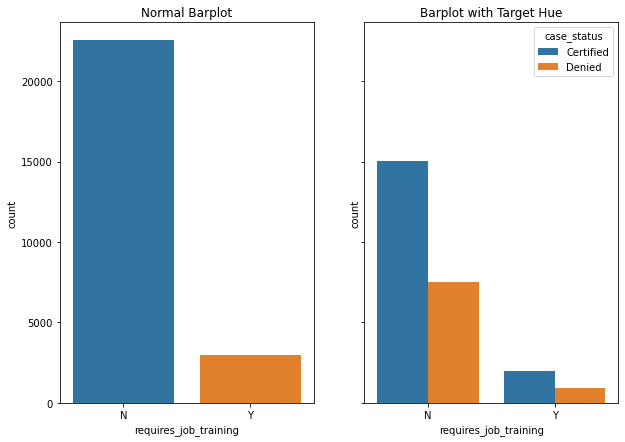

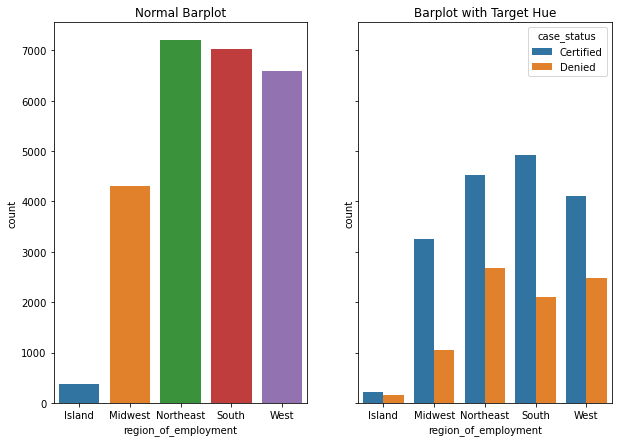

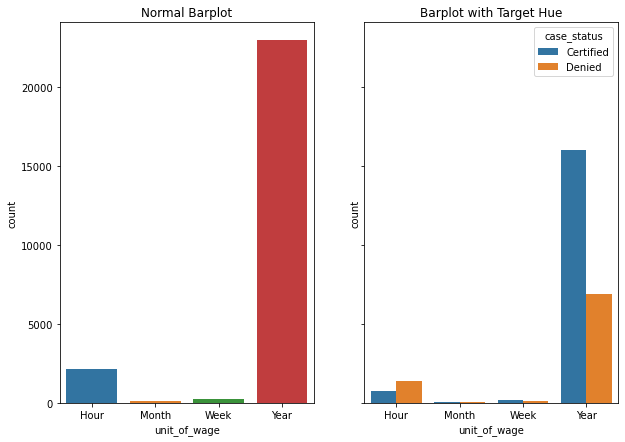

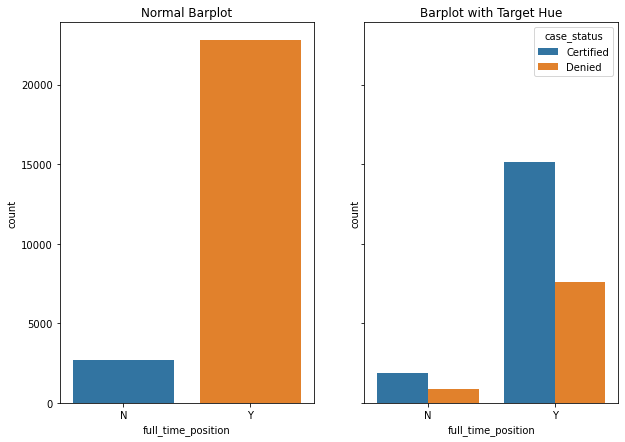

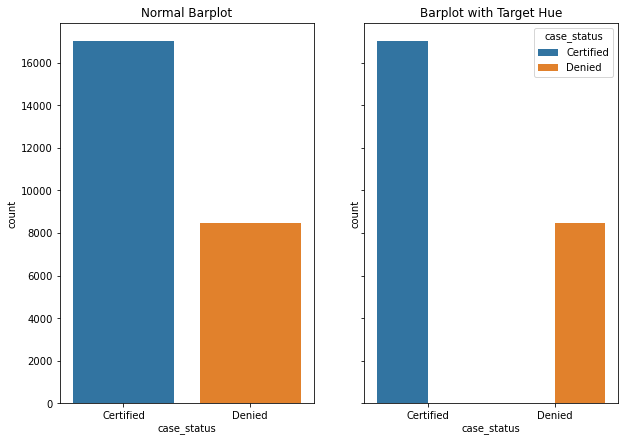

In [17]:
# Create a bar hue plot for all categorical data. 
for col in cat_cols:
    
    bar_hue_plot(data, col, 'case_status')

#### Observations:

`continent`

-  The majority of the data is from Asia.
- The distribution of the target variable roughly follows the distribution of the total data.

`education_of_employee`

- The majority of the entries are either Bachelor's or Master's degrees. Doctorate is the least represented.
- All degreed entries are more likely than not to be certified. The liklihood increases with the degree level.
- High school education has a higher liklihood to be denied a VISA.

`has_job_experience`

- The majority of entries in the data set have job experience.
- However, having job experience or not, an entry is more likely to be certified than denied.
- Those with job experience are MORE likely to be certified than those without.

`requires_job_training`

- The majority of the dataset does not require job training.
- Both requiring job experience and not, each is more likely to be certified than denied.
- However, not requiring job experience is more likely to be certified than requiring it.

`region_of_employment`

- The majority of entries are in the Northeast, South, and West, nearly evenly distrubuted. Island region is the least.
- The distribution of the target variable roughtly follows the distribution of the total data.

`unit_of_wage`

- The vast majority of entries are salaried employees.
-  Salaried employees are more likely to be certified than denied.
- Hourly employees are more likely to be denied than certified.

`full_time_position`

- The vast majority of entries are full time positions.
- Both full time and part time positions are more likely to be certified than denied.
- However, full time positions increase the liklihood that an entry is certified.


### Multivariate Analysis and Leading Questions

<AxesSubplot:>

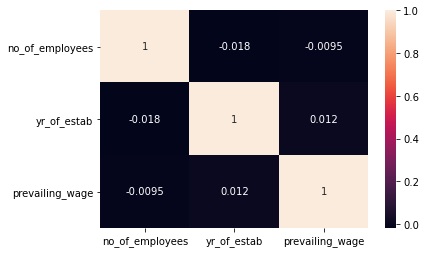

In [18]:
# Create a heatmap to understand the variable correlation.

sns.heatmap(data.corr(), annot = True)

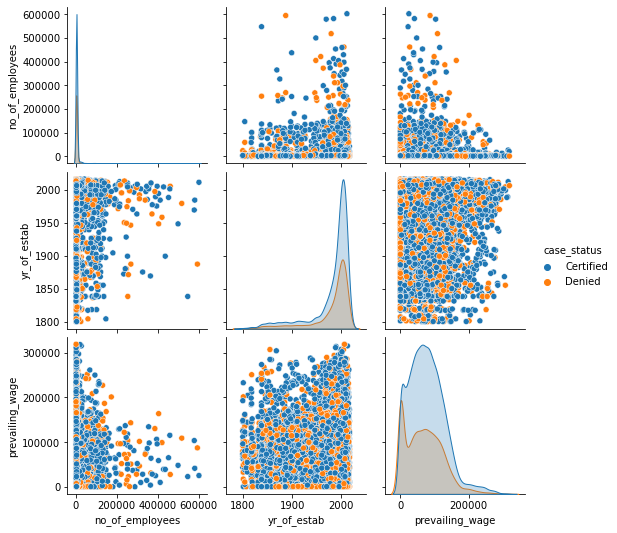

In [19]:
# Create a pair plot to understand the numerical relationships
sns.pairplot(data = data, hue = 'case_status');

#### Observations:

- Based on the multivariate analysis, there are no obvious relationships amoung the numeric variables. 

**Leading Questions**:
1. Those with higher education may want to travel abroad for a well-paid job. Does education play a role in Visa certification? 


In [20]:
data.groupby('education_of_employee')['case_status'].value_counts(normalize = True)

education_of_employee  case_status
Bachelor's             Certified      0.622142
                       Denied         0.377858
Doctorate              Certified      0.872263
                       Denied         0.127737
High School            Denied         0.659649
                       Certified      0.340351
Master's               Certified      0.786278
                       Denied         0.213722
Name: case_status, dtype: float64

<AxesSubplot:xlabel='education_of_employee', ylabel='count'>

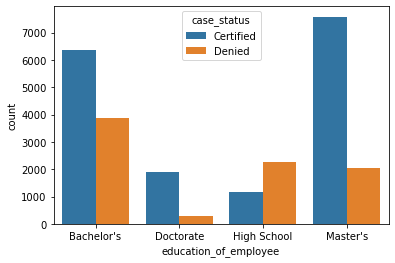

In [21]:
sns.countplot(data = data, x = 'education_of_employee', hue = 'case_status')

#### Observations:

- Higher levels of education result in higher liklihood that a VISA is certified.
- High school education only results in higher liklihood that a VISA is denied.

2. How does the visa status vary across different continents? 


In [22]:
data.groupby('continent')['case_status'].value_counts(normalize = True)

continent      case_status
Africa         Certified      0.720508
               Denied         0.279492
Asia           Certified      0.653105
               Denied         0.346895
Europe         Certified      0.792337
               Denied         0.207663
North America  Certified      0.618773
               Denied         0.381227
Oceania        Certified      0.635417
               Denied         0.364583
South America  Certified      0.578638
               Denied         0.421362
Name: case_status, dtype: float64

<AxesSubplot:xlabel='continent', ylabel='count'>

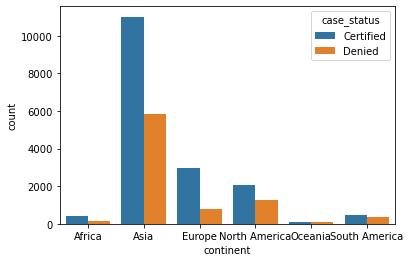

In [23]:
sns.countplot(data = data, x = 'continent', hue = 'case_status')

#### Observations:

- The majority of visa entries are from Asia.
- For each continent, VISAs are more likely to be certified than denied.

3. Experienced professionals might look abroad for opportunities to improve their lifestyles and career development. Does work experience influence visa status? 


In [24]:
data.groupby('has_job_experience')['case_status'].value_counts(normalize = True)

has_job_experience  case_status
N                   Certified      0.561341
                    Denied         0.438659
Y                   Certified      0.744764
                    Denied         0.255236
Name: case_status, dtype: float64

<AxesSubplot:xlabel='has_job_experience', ylabel='count'>

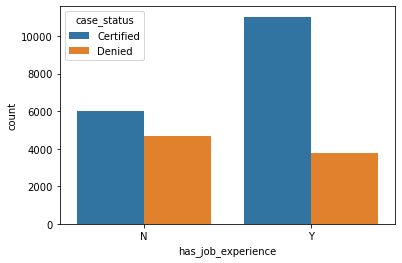

In [25]:
sns.countplot(data = data, x = 'has_job_experience', hue = 'case_status')

#### Observations:

- Work experience results in a higher liklihood that a VISA is certified.

4. In the United States, employees are paid at different intervals. Which pay unit is most likely to be certified for a visa? 

In [26]:
data.groupby('unit_of_wage')['case_status'].value_counts(normalize = True)

unit_of_wage  case_status
Hour          Denied         0.653686
              Certified      0.346314
Month         Certified      0.617978
              Denied         0.382022
Week          Certified      0.621324
              Denied         0.378676
Year          Certified      0.698850
              Denied         0.301150
Name: case_status, dtype: float64

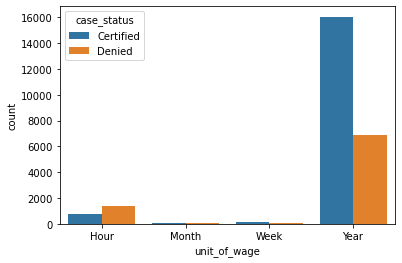

In [27]:
sns.countplot(data = data, x = 'unit_of_wage', hue = 'case_status');

#### Observations:

- Salaried employees are much more likely to be certified than denied.
- Hourly employees are slightly less likely to be certified than denied.

5. The US government has established a prevailing wage to protect local talent and foreign workers. How does the visa status change with the prevailing wage?

In [28]:
data.groupby('prevailing_wage')['case_status'].value_counts()

prevailing_wage  case_status
2.1367           Certified      1
2.9561           Denied         1
3.0031           Denied         1
3.3188           Denied         1
3.4889           Certified      1
                               ..
311734.4900      Certified      1
314156.0600      Certified      1
315497.6000      Certified      1
318446.0500      Certified      1
319210.2700      Denied         1
Name: case_status, Length: 25462, dtype: int64

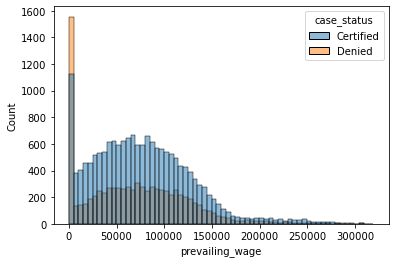

In [29]:
sns.histplot(data = data, x = 'prevailing_wage', hue = 'case_status');

#### Observations:

- The overall distribution follows the target variable distribution in the overall data.
- For a 0 wage (interpreted as having no job) entries are more likely to be denied than certified.

## Data Preprocessing

- Missing value treatment (if needed)
- Feature engineering 
- Outlier detection and treatment (if needed)
- Preparing data for modeling 
- Any other preprocessing steps (if needed)

In [30]:
# Check the data types for pre-processing
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  category
 1   education_of_employee  25480 non-null  category
 2   has_job_experience     25480 non-null  category
 3   requires_job_training  25480 non-null  category
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  category
 7   prevailing_wage        25480 non-null  float64 
 8   unit_of_wage           25480 non-null  category
 9   full_time_position     25480 non-null  category
 10  case_status            25480 non-null  category
dtypes: category(8), float64(1), int64(2)
memory usage: 797.7 KB


In [31]:
# Check the summary stats for all variables to identify anomolies
data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
continent,25480,6,Asia,16861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_of_employee,25480,4,Bachelor's,10234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_job_experience,25480,2,Y,14802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requires_job_training,25480,2,N,22525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_employees,25480.0,NaN,NaN,NaN,5667.04321,22877.928848,-26.0,1022.0,2109.0,3504.0,602069.0
yr_of_estab,25480.0,NaN,NaN,NaN,1979.409929,42.366929,1800.0,1976.0,1997.0,2005.0,2016.0
region_of_employment,25480,5,Northeast,7195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prevailing_wage,25480.0,NaN,NaN,NaN,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27
unit_of_wage,25480,4,Year,22962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full_time_position,25480,2,Y,22773,NaN,NaN,NaN,NaN,NaN,NaN,NaN



- `no_of_employees` has a negative number as a minimum. This needs addressed

In [32]:
# Set every instance of no_of_employees to 1
data.loc[data['no_of_employees'] < 0, 'no_of_employees'] = 1 

In [33]:
# Check value counts for all variables
for col in data.columns.tolist():
    
    print(data[col].value_counts())
    print('*' * 50)

Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: continent, dtype: int64
**************************************************
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: education_of_employee, dtype: int64
**************************************************
Y    14802
N    10678
Name: has_job_experience, dtype: int64
**************************************************
N    22525
Y     2955
Name: requires_job_training, dtype: int64
**************************************************
1         33
183       18
724       16
854       16
766       15
          ..
5670       1
221303     1
4217       1
5654       1
8100       1
Name: no_of_employees, Length: 7101, dtype: int64
**************************************************
1998    1134
2005    1051
2001    1017
2007     994
1999     870
        ... 
1820       6
1846       4
1822       4
1810       3
182

- Need to deal with the Y/N variables

#### Outlier Treatment

In [34]:
num_cols

['no_of_employees', 'yr_of_estab', 'prevailing_wage']

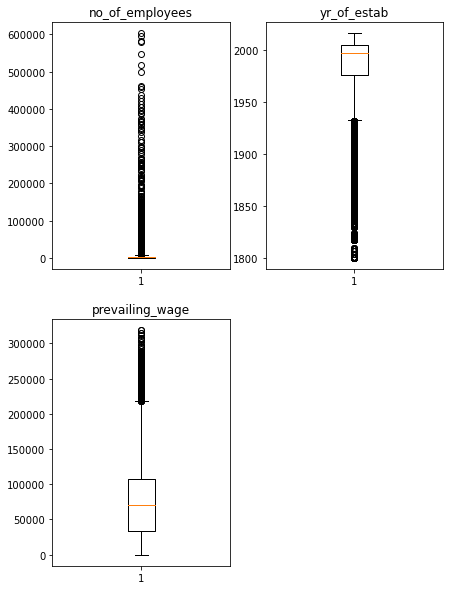

In [35]:
# Check out the box plots of the numerical data columns

plt.figure(figsize=(7, 10))

for i, variable in enumerate(num_cols):
    plt.subplot(2, 2, i + 1)
    plt.title(variable)
    plt.boxplot(data = data, x = variable)
    

plt.show()

#### Observations:

- All of the numeric variables have strong outliers. 
- Since linearity and normal distribution is not a concern for ensemble models, the outliers will remain untreated.
- In this case, outliers are considered important data.

In [36]:
# Create a dictionary to map the Y/N column to booleans
yn_map = {
    'Y': 1,
    'N': 0
}

In [37]:
# Select the columns to apply the dictionary
cols_to_yn_bin = ['has_job_experience','requires_job_training', 'full_time_position']

In [38]:
# Apply the dictionary to the selected columns
for col in cols_to_yn_bin:
    
    data[col] = data[col].map(yn_map)

#### Data Transformations

In [39]:
# Import the standard scaler
std_scaler = StandardScaler()

In [40]:
# Review the num_cols variable
num_cols

['no_of_employees', 'yr_of_estab', 'prevailing_wage']

Since the `yr_of_estab` variable is a year, the scaling is different and should 
not have the transformation applied.

In [41]:
# Create a new transformed column for the desired variables

data['no_of_employees_z'] = std_scaler.fit_transform(data[['no_of_employees']])
data['prevailing_wage_z'] = std_scaler.fit_transform(data[['prevailing_wage']])
    

#### No_of_employees Transformed

Standard Scaler Transformation

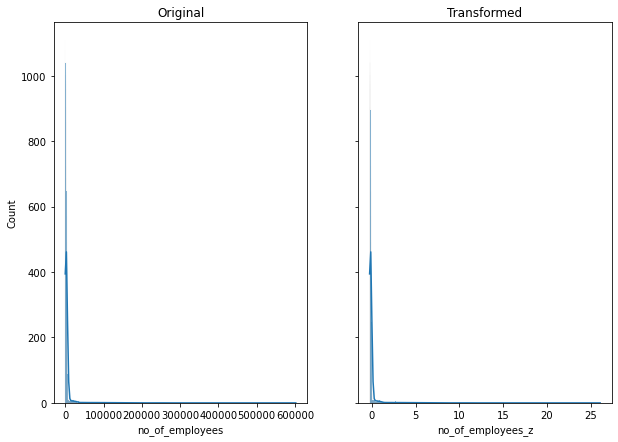

In [42]:
# Plot the original data alongside the transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,7))

ax1.set_title('Original')
ax2.set_title('Transformed')

sns.histplot(data, x = 'no_of_employees', ax = ax1, kde = True)
sns.histplot(data, x = 'no_of_employees_z', ax = ax2, kde = True)
plt.show()

Log Transformation

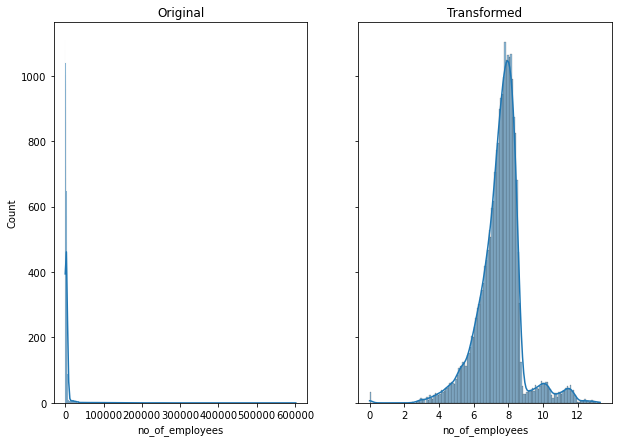

In [43]:
# Plot the original data alongside the transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,7))

ax1.set_title('Original')
ax2.set_title('Transformed')

sns.histplot(data, x = 'no_of_employees', ax = ax1, kde = True)
sns.histplot(data, x = np.log(data['no_of_employees']), ax = ax2, kde = True)

plt.show()

#### Observations:

- With the highly skewed `no_of_employees` variable, a log transformation is ideal to spread the data into a consistent, manageable range.

In [44]:
# Create a column with the log transformed data
data['no_of_employees_log'] = np.log(data['no_of_employees'])

In [45]:
# Drop the raw data columns
data.drop(['no_of_employees', 'no_of_employees_z'], axis = 1, inplace = True)

#### Prevailing Wage Transformed

Standard Scaler Transformation

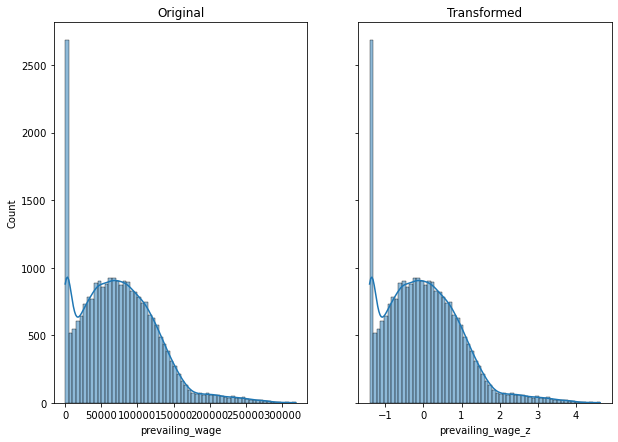

In [46]:
# Plot the original data alongside the transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,7))

ax1.set_title('Original')
ax2.set_title('Transformed')

sns.histplot(data, x = 'prevailing_wage', ax = ax1, kde = True)
sns.histplot(data, x = 'prevailing_wage_z', ax = ax2, kde = True)
plt.show()

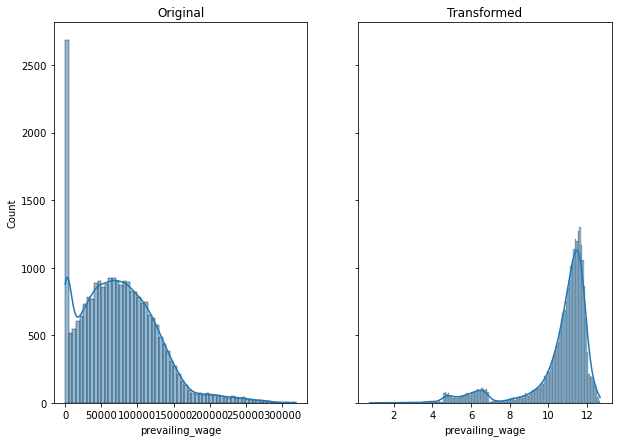

In [47]:
# Plot the original data alongside the transformed data
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,7))

ax1.set_title('Original')
ax2.set_title('Transformed')

sns.histplot(data, x = 'prevailing_wage', ax = ax1, kde = True)
sns.histplot(data, x = np.log(data['prevailing_wage']), ax = ax2, kde = True)

plt.show()

#### Observations:

- The scale of the original data is very large compared to the rest of the data.
- The standard scaler shifts the data down to reasonable levels but doesn't handle the skewness of the data.
- The log of the data shifts a lot of the data but allows for properly scaled data.

In [48]:
# Create a column with the log transformed data
data['prevailing_wage_log'] = np.log(data['prevailing_wage'])

In [49]:
# Drop the undesired columns
data.drop(['prevailing_wage', 'prevailing_wage_z'], axis = 1, inplace = True)

#### Year Transformed-ish

In [50]:
# Find the maximum value in the year list
current_yr = data['yr_of_estab'].max()

In [51]:
# Create a new column to determine how many years the company has been established
data['yr_since_estab'] = current_yr - data['yr_of_estab']

In [52]:
# Drop the undesired columns
data.drop('yr_of_estab', axis = 1, inplace = True)

### Independent and Dependent variables

In [53]:
# Create X and y variables 
# Dummies required for Logistic Regression
# Convert case status to boolean
X = data.drop('case_status', axis = 1)
X = pd.get_dummies(X, drop_first = True)
y = data['case_status'].replace(['Certified', 'Denied'], [1, 0])

## EDA

- It is a good idea to explore the data once again after manipulating it.

In [54]:
# Check the top rows
X.head()

,no_of_employees_log,prevailing_wage_log,yr_since_estab,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,education_of_employee_Doctorate,education_of_employee_High School,...,has_job_experience_1,requires_job_training_1,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,full_time_position_1
0,9.582800,6.383849,9,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,7.788212,11.331711,14,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
2,10.701985,11.719914,8,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,1
3,4.584967,11.331812,119,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,6.986566,11.917773,11,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1


In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   no_of_employees_log                25480 non-null  float64
 1   prevailing_wage_log                25480 non-null  float64
 2   yr_since_estab                     25480 non-null  int64  
 3   continent_Asia                     25480 non-null  uint8  
 4   continent_Europe                   25480 non-null  uint8  
 5   continent_North America            25480 non-null  uint8  
 6   continent_Oceania                  25480 non-null  uint8  
 7   continent_South America            25480 non-null  uint8  
 8   education_of_employee_Doctorate    25480 non-null  uint8  
 9   education_of_employee_High School  25480 non-null  uint8  
 10  education_of_employee_Master's     25480 non-null  uint8  
 11  has_job_experience_1               25480 non-null  uin

In [56]:
# Check the shape of the independent variables
X.shape

(25480, 21)

In [57]:
# Check the top rows of the dependent variable
y.head()

0    0
1    1
2    0
3    0
4    1
Name: case_status, dtype: int64

In [58]:
y.shape

(25480,)

## Building bagging and boosting models

#### Model Set up
##### We are going to build 7 models (1 singular model, 6 ensemble models)
- Decision Tree
- Bagging Classifier
- Random Forest Classifier
- AdaBoost Classifier
- Gradient Boosting Classifier
- XGBoost Classifier
- Stacking Classifier


##### Two ways the model can fail:
<ol>
    <li>Predict that a VISA will be approved when it is actually denied.</li>
    <li>Predict that a VISA will be denied when it is actually approved.</li>
</ol>

##### Which is more important?
- Since the purpose of applying machine learning to this problem is to idenfity which factors are most likely to result in an APPROVED VISA, it is very important that the chosen model successfully predicts the approved VISAs. 
- That said, if a model predicts a VISA will be approved and it is denied, this will be detrimental to the well-being of the individual, the overall trust in the models, and a potential mis-use of resources.
- But if a model predicts a VISA will be denied and it is approved, this will also diminish trust in the model and also incorrectly use resourcse as the approved VISA was not properly prepaired for.
- So, all major metrics will be calculated: Accuracy, Precision, Recall, and f1 score.
- However, for the purposes of this problem, the `f1 score` is the metric of focus. High f1 score indicates low false positives AND low false negatives, or low chances of incorrectly predicting either case incorrectly.

In [59]:
# The following function is courtesy of sklearn and GreatLearning
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [60]:
# THe following function is courtesy of sklearn and GreatLearning
# Create a function to produce a confusion matrix of the data.
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [61]:
# Create a function to easily combine the training and testing data metrics. Only showing the confusion matrix of the test data.
def get_scores(model):

    train = model_performance_classification_sklearn(model, X_train, y_train)
    test = model_performance_classification_sklearn(model, X_test, y_test)
    
    print(f'Training Performance: \n {train} \n')
    print(f'Test Performance: \n {test} \n')
    confusion_matrix_sklearn(model, X_test, y_test)
    
    return train, test

In [62]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [63]:
X_train.shape

(17836, 21)

In [64]:
y_train.head()

21       1
7332     1
20579    0
22326    1
13237    0
Name: case_status, dtype: int64

### Decision Tree

In [65]:
# Create decision tree classified with default parameters
clf_dt = DecisionTreeClassifier(random_state = 1)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

Training Performance: 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Test Performance: 
    Accuracy    Recall  Precision       F1
0  0.659079  0.743781    0.74524  0.74451 



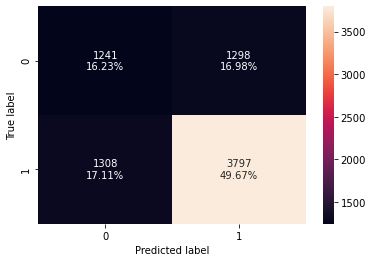

In [66]:
# Get the scores of the training and test sets
clf_dt_train, clf_dt_test = get_scores(clf_dt)

### Bagging

In [67]:
# Create a bagging classifier with default parameters
clf_bag = BaggingClassifier(random_state = 1)
clf_bag.fit(X_train, y_train)

BaggingClassifier(random_state=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.985647  0.986485   0.991981  0.989226 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.696363  0.766699   0.775971  0.771308 



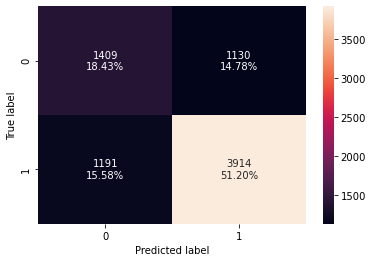

In [68]:
# Get the scores of the training and test sets
clf_bag_train, clf_bag_test = get_scores(clf_bag)

### Random Forest

In [69]:
# Create a random forest classifier with default parameters
clf_rf = RandomForestClassifier(random_state = 1)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

Training Performance: 
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.719519  0.832909   0.767094  0.798648 



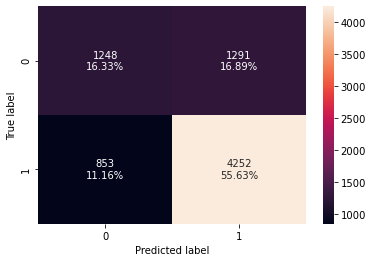

In [70]:
# Get the scores of the training and test sets
clf_rf_train, clf_rf_test = get_scores(clf_rf)

### AdaBoost

In [71]:
# Create an Adaptive Boosting Classifier with the default parameters
clf_ab = AdaBoostClassifier(random_state = 1)
clf_ab.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0   0.73789  0.887686   0.760135  0.818974 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.733255  0.885406   0.756612  0.815958 



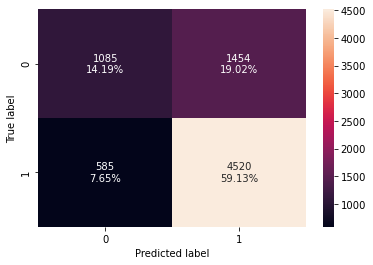

In [72]:
# Get the scores of the training and test sets
clf_ab_train, clf_ab_test = get_scores(clf_ab)

### Gradient Boosting

In [73]:
# Create a Gradient Boosting Classified with default parameters
clf_gbm = GradientBoostingClassifier(random_state = 1)
clf_gbm.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

Training Performance: 
    Accuracy    Recall  Precision       F1
0  0.759083  0.883153   0.783629  0.83042 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.746206  0.875024   0.774311  0.821593 



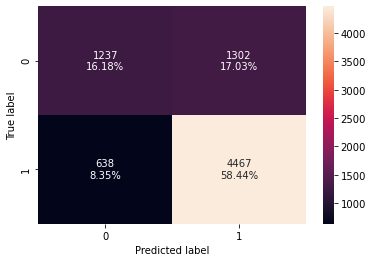

In [74]:
# Get the scores of the training and test sets
clf_gbm_train, clf_gbm_test = get_scores(clf_gbm)

### XGBoost

In [75]:
# Create an XGBoost Classifier with default parameters
clf_xgb = XGBClassifier(random_state = 1, eval_metric = 'logloss')
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.840603  0.932091   0.845182  0.886512 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.731293  0.858178   0.767116  0.810096 



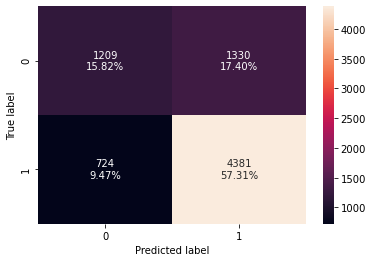

In [76]:
# Get the scores of the training and test sets
clf_xgb_train, clf_xgb_test = get_scores(clf_xgb)

##### Comparing the standard models

In [77]:
# standard model test performance comparison

std_models_comp_df = pd.concat(
    [clf_dt_test.T, clf_bag_test.T,
    clf_rf_test.T, clf_ab_test.T,
    clf_gbm_test.T, clf_xgb_test.T],
    axis=1,
)
std_models_comp_df.columns = [
    "Decision Tree",
    "Bagging Classifier",
    "Random Forest Classifier",
    "AdaBoost Classifier",
    "Gradient Boost Classifier",
    'XGBoost Classifier']


std_models_comp_df

,Decision Tree,Bagging Classifier,Random Forest Classifier,AdaBoost Classifier,Gradient Boost Classifier,XGBoost Classifier
Accuracy,0.659079,0.696363,0.719519,0.733255,0.746206,0.731293
Recall,0.743781,0.766699,0.832909,0.885406,0.875024,0.858178
Precision,0.745240,0.775971,0.767094,0.756612,0.774311,0.767116
F1,0.744510,0.771308,0.798648,0.815958,0.821593,0.810096


#### Observations:

- Based on un-tuned models, Gradient Boosting (82.1) and Adaptive Boosting (81.6) produced the best f1 score.
- The worst f1 score is the single decision tree model. This model, along with the random forest, greatly suffers from overfitting to the training data. 
- The most balanced model is the Adaptive Boosted model.

##  Will tuning the hyperparameters improve the model performance?

#### Decision Tree - Tuned

In [78]:
# Choose the type of classifier.
clf_dt_tuned = DecisionTreeClassifier(random_state = 1)

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, None],
    "criterion": ["entropy", "gini"],
    "splitter": ["best", "random"],
    "min_impurity_decrease": [0.00001, 0.0001, 0.01],
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf_dt_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_dt_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf_dt_tuned.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5,
                       min_impurity_decrease=1e-05, random_state=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.739516  0.920339   0.747834  0.825167 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.727891  0.916357   0.738904  0.818118 



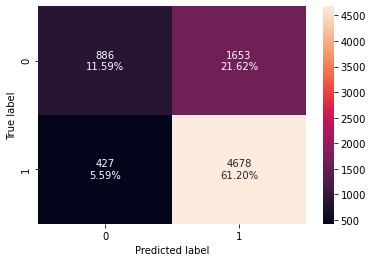

In [79]:
clf_dt_tuned_train, clf_dt_tuned_test = get_scores(clf_dt_tuned)

### Bagging - Tuned

In [80]:
clf_bag_tuned = BaggingClassifier(random_state = 1)

parameters = {
    'base_estimator': [DecisionTreeClassifier(random_state = 1), LogisticRegression(solver = 'liblinear', random_state = 1)],
    'max_samples': [0.7, 0.8, 0.9, 1],
    'max_features': [0.7, 0.8, 0.9, 1],
    'n_estimators': [10, 20, 30, 40, 50]
}

score = make_scorer(f1_score)

grid_obj = GridSearchCV(clf_bag_tuned, parameters, scoring = score)
grid_obj = grid_obj.fit(X_train, y_train)

clf_bag_t = grid_obj.best_estimator_

clf_bag_tuned.fit(X_train, y_train)

BaggingClassifier(random_state=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.985647  0.986485   0.991981  0.989226 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.696363  0.766699   0.775971  0.771308 



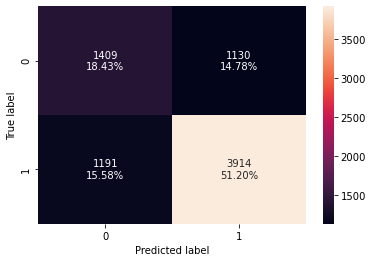

In [81]:
clf_bag_tuned_train, clf_bag_tuned_test = get_scores(clf_bag_tuned)

### Random Forest - Tuned

In [82]:
# Choose the type of classifier. 
clf_rf_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    'n_estimators': np.arange(50, 250, 50),
    'min_samples_leaf': np.arange(4, 11, 2),
    'max_features': np.arange(0.2, 0.8, 0.2),
    'max_samples': np.arange(0.3, 0.7, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf_rf_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf_rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features=0.4, max_samples=0.3, min_samples_leaf=8,
                       n_estimators=200, random_state=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.769847  0.883657    0.79473  0.836838 

Test Performance: 
    Accuracy    Recall  Precision       F1
0   0.74686  0.870911   0.777001  0.82128 



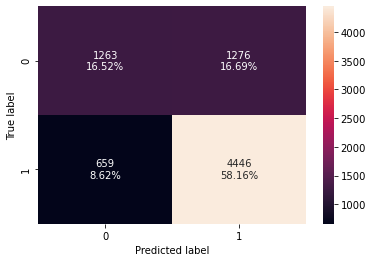

In [83]:
clf_rf_tuned_train, clf_rf_tuned_test = get_scores(clf_rf_tuned)

### AdaBoost - Tuned

In [84]:
# Choose the type of classifier. 
clf_ab_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth = 1, random_state = 1), DecisionTreeClassifier(max_depth = 2, random_state = 1), DecisionTreeClassifier(max_depth = 3, random_state = 1)],
    "n_estimators": np.arange(10, 100, 10),
    "learning_rate":np.arange(0.1, 2, 0.25)
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf_ab_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_ab_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf_ab_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.1, random_state=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0   0.75314  0.888189   0.775051  0.827772 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.740842  0.881881   0.765646  0.819663 



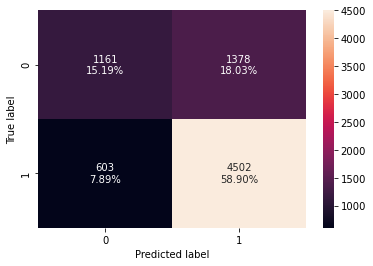

In [85]:
clf_ab_tuned_train, clf_ab_tuned_test = get_scores(clf_ab_tuned)

### Gradient Boosting - Tuned

In [86]:
# Choose the type of classifier. 
clf_gbm_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf_gbm_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_gbm_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf_gbm_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.7, random_state=1, subsample=1)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.758074  0.882313   0.783001  0.829696 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.745814  0.874829   0.774003  0.821333 



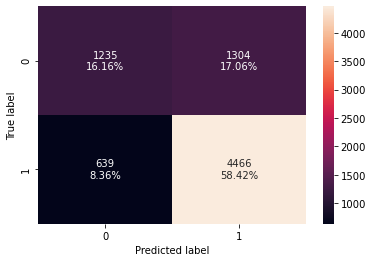

In [87]:
clf_gbm_tuned_train, clf_gbm_tuned_test = get_scores(clf_gbm_tuned)

### XGBoost - Tuned

Due to time constraints and hardware limitations, this model was never able to finish running and has been commented out. 

However, the code is left in for reference.

In [88]:
# Choose the type of classifier. 
clf_xgb_tuned = XGBClassifier(random_state = 1,eval_metric = 'logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": [40],
    "scale_pos_weight": [1], # Tried all of the following [0, 1, 2, 5],
    "subsample": [1], # Tried all of the following [0.5, 0.7, 0.9, 1],
    "learning_rate": [0.1], # Tried all of the following [0.01, 0.1, 0.2, 0.05],
    "gamma": [3], #[0, 1, 3],
    "colsample_bytree": [0.5], #[0.5, 0.7, 0.9, 1],
    "colsample_bylevel": [0.7] #[0.5, 0.7, 0.9, 1]
}

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf_xgb_tuned, parameters, scoring = scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf_xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
clf_xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='logloss', gamma=3,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.762839  0.891799   0.783192  0.833974 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.746729  0.881881   0.771551  0.823035 



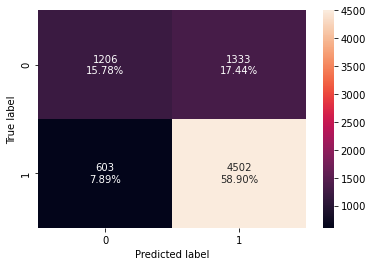

In [89]:
clf_xgb_tuned_train, clf_xgb_tuned_test = get_scores(clf_xgb_tuned)

In [90]:
std_models_comp_df

,Decision Tree,Bagging Classifier,Random Forest Classifier,AdaBoost Classifier,Gradient Boost Classifier,XGBoost Classifier
Accuracy,0.659079,0.696363,0.719519,0.733255,0.746206,0.731293
Recall,0.743781,0.766699,0.832909,0.885406,0.875024,0.858178
Precision,0.745240,0.775971,0.767094,0.756612,0.774311,0.767116
F1,0.744510,0.771308,0.798648,0.815958,0.821593,0.810096


### Stacking Classifier

In [92]:
estimators = [
    ('Random Forest', clf_rf_tuned),
    ('Adaptive Boost', clf_ab_tuned),
    ('Gradient Boost', clf_gbm_tuned)
]

final_estimator = clf_xgb_tuned

clf_stack = StackingClassifier(estimators = estimators, final_estimator = final_estimator, cv = 5)
clf_stack.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('Random Forest',
                                RandomForestClassifier(max_features=0.4,
                                                       max_samples=0.3,
                                                       min_samples_leaf=8,
                                                       n_estimators=200,
                                                       random_state=1)),
                               ('Adaptive Boost',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                                         random_state=1),
                                                   learning_rate=0.1,
                                                   random_state=1)),
                               ('Gradient Boost',
                                GradientBoostingClassifier(init=Ada...
                                          

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.765979  0.883069   0.790918  0.834457 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.744898  0.871499   0.774682  0.820243 



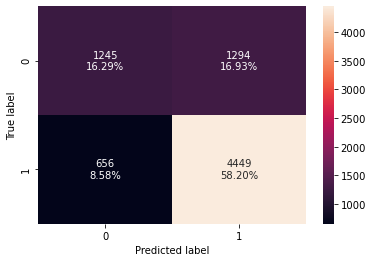

In [93]:
clf_stack_train, clf_stack_test = get_scores(clf_stack)

## Model Performance Comparison and Conclusions

In [94]:
# tuned model test performance comparison

tuned_models_comp_df = pd.concat(
    [clf_dt_tuned_test.T, clf_bag_tuned_test.T,
    clf_rf_tuned_test.T, clf_ab_tuned_test.T,
    clf_gbm_tuned_test.T, clf_xgb_tuned_test.T,
    clf_stack_test.T],
    axis=1,
)
tuned_models_comp_df.columns = [
    'Tuned Decision Tree',
    'Tuned Bagging Classifier',
    'Tuned Random Forest Classifier',
    'Tuned AdaBoost Classifier',
    'Tuned Gradient Boost Classifier',
    'Tuned XGBoost Classifier',
    'Stacked Classifier']


tuned_models_comp_df

,Tuned Decision Tree,Tuned Bagging Classifier,Tuned Random Forest Classifier,Tuned AdaBoost Classifier,Tuned Gradient Boost Classifier,Tuned XGBoost Classifier,Stacked Classifier
Accuracy,0.727891,0.696363,0.746860,0.740842,0.745814,0.746729,0.744898
Recall,0.916357,0.766699,0.870911,0.881881,0.874829,0.881881,0.871499
Precision,0.738904,0.775971,0.777001,0.765646,0.774003,0.771551,0.774682
F1,0.818118,0.771308,0.821280,0.819663,0.821333,0.823035,0.820243


In [95]:
# Reprint the standard model comparison
std_models_comp_df

,Decision Tree,Bagging Classifier,Random Forest Classifier,AdaBoost Classifier,Gradient Boost Classifier,XGBoost Classifier
Accuracy,0.659079,0.696363,0.719519,0.733255,0.746206,0.731293
Recall,0.743781,0.766699,0.832909,0.885406,0.875024,0.858178
Precision,0.745240,0.775971,0.767094,0.756612,0.774311,0.767116
F1,0.744510,0.771308,0.798648,0.815958,0.821593,0.810096


#### Final Model: Tuned XGBoost

Training Performance: 
    Accuracy    Recall  Precision        F1
0  0.762839  0.891799   0.783192  0.833974 

Test Performance: 
    Accuracy    Recall  Precision        F1
0  0.746729  0.881881   0.771551  0.823035 



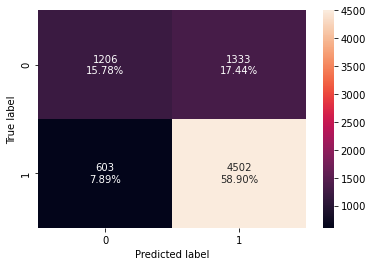

In [96]:
get_scores(clf_xgb_tuned);

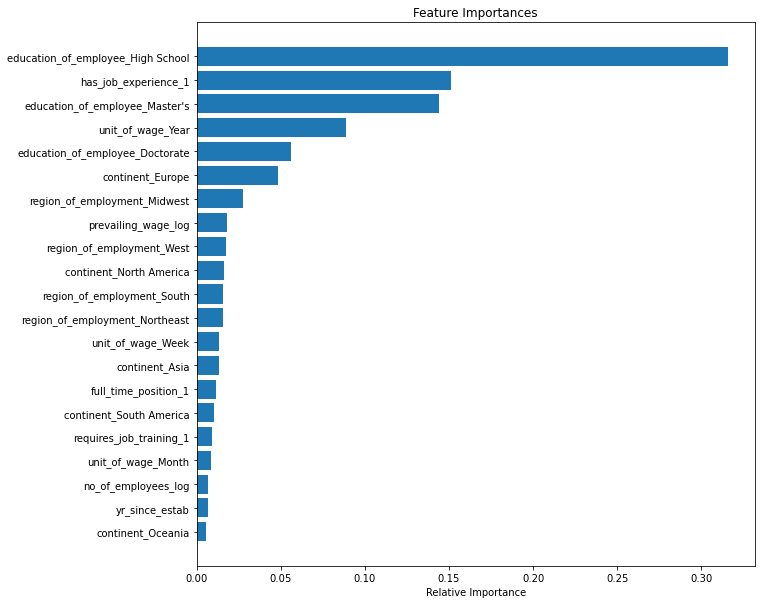

In [97]:
# Create a plot to show the relative importances of each variable.
names = X_train.columns
importances = clf_xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Observations:

- Having a a high school education is the biggest influence on VISA approval status.
- Followed by having job experience. 

## Actionable Insights and Recommendations

#### Insights and Summary:

- Based on the data, this model is able to predict the approval status of a work VISA with an `f1 score` of 82.3%. This metric was used in order to minimize overall incorrect predictions (minimize false positives and false negatives together)

- Factors that influence the VISA status:
  - Education Level
  - Previous Job Experience
  - Higher for a Salary (paid yearly) position


- For education level, high school level is the biggest single influence out of all the variables. Based on the data analysis above, it is safe to assume that this variable NEGATIVELY impacts the liklihood of VISA approval. 
- On the other end of the spectrum, a Master's or Doctorate degress have a large POSTIVE impact on the approval liklihood. 

#### Recommendations:

Original Objective:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 

Based on these objectives, certifying or denying a work VISA has been made easier by identifying the factors that influence approval. 

For applicants, the best way to increase your chances of approval are increase your education. However, the below recommendations can be made to improve the chances of VISA approval for all applicants.

-  Applicants with only a high school education are most likely to be denied. To better the chances, have significant work experience and apply to positions in the Midwest. If you are from Europe, your chances will be improved slightly (sorry non-Europeans.)

- Applicants with a Master's or Doctorate degree have a high liklihood of being accepted, with a Doctorate slightly edging out a Master's. 

- Applicants with a Bachelor's degree or above can all significantly increase their chances by having previous professional work experience. Professional experience that pays an annual salary will further increase chances.